

# Agent-Based Modeling on Networks

Many of the problems that interest us in networks relate to agents making actions or decisions on network structures. While in some cases we can develop relatively complete mathematical descriptions of systems like these, in other cases we need to perform computational simulations and experiments. In this set of notes, we'll focus on basic techniques for *agent-based modeling* (ABM) in Python.

In agent-based modeling, we construct a model by defining a set of agents and the rules by which those agents interact. There are many good software packages for agent-based modeling, perhaps the most famous of which is [NetLogo](https://en.wikipedia.org/wiki/NetLogo). [For even more comparisons, see [this page](https://en.wikipedia.org/wiki/Comparison_of_agent-based_modeling_software).]{.aside} In this class, we'll use one of several agent-based modeling frameworks developed for Python, called [mesa](https://mesa.readthedocs.io/en/latest/). Mesa includes a number of useful tools for constructing, analyzing, and visualizing agent-based models. You can install Mesa using

```{bash}
pip install mesa
```

at the command line or by searching for and installing it in the Environments tab of Anaconda Navigator. Once you've installed Mesa, you are ready to use its tools.

## Components of an Agent-Based Model

Let's start with some vocabulary. A Mesa model has several components:

- An **agent** is a representation of the individuals who make decisions and perform actions. Agents have a `step()` method that describes their behavior.
- The **grid** is a representation of relationships between individuals. The grid can be, say, a 2d rectangle, in which case we could imagine it representing space. In this class, we'll of course use a *network grid*, in which we can use a network to specify relationships.
- The **data collector** helps us gather data on our simulation.

## First Example: Simple Random Walk

For our first agent-based model, we are going to code up an agent-based implementation of the simple random walk. There are lots of reasonable ways to do this, and Mesa is actually a bit of overkill for this particular problem. Still, we'll learn some important techniques and concepts along the way.

Let's start by importing several tools that we'll use.

In [3]:
from mesa import Model, Agent                 # core mesa classes
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

Since this is a networks class, we'll use a network-based grid. We imported the capability to do that above as the `mesa.space.NetworkGrid` class. Of course, we need a network to use. For this example, we'll use the Les Miserable Graph, which is built in to NetworkX:

In [4]:
G = nx.les_miserables_graph()
G = nx.convert_node_labels_to_integers(G)

We'll soon use this to create our model.

### The Model Class

To specify an ABM in Mesa we need to define two classes: a class describing the model and a class describing each individual agent. The main responsibilities of the model class are to describe:

- How the model is initialized, via the `__init__()` method. This includes:
    - Creating any agents needed.
    - Placing those agents on the grid and placing them in the schedule.
    - Defining any data collection tools.
- What happens in a single time-step of the model, via the `step()` method.

The model class actually has a lot more functionality than this. Fortunately, we don't usually need to define this functionality, because the model class we create inherits the needed functionality from `mesa.Model` (which we imported above). Here's our `SRWModel` class. The syntax can look a little complicated whenever we work with a new package, but what's going on is fundamentally pretty simple. We've added annotations next to the most important lines of code; other lines are also necessary for correct functioning but are more boilerplate than informative.

In [26]:
class RWModel(Model):
  def __init__(self, G, agent_class, **kwargs):
    super().__init__()

    # add the network G as a grid
    self.grid = NetworkGrid(G)

    # add agents to the model
    self.agent = agent_class(self, **kwargs)
    node = np.random.choice(list(G.nodes))
    self.grid.place_agent(self.agent, node)

    # add a data collector
    self.collector = DataCollector(
        agent_reporters = {"node": lambda a: a.pos}
    )

  def step(self):
    self.agent.step()
    self.collector.collect(self)

1. We initialize the model and choose its arguments. In this case, the arguments are `G`.
2. The `self.grid` object defines the space on which agents move. In our case, we can make a `NetworkGrid` object directly out of a `NetworkX` graph `G`.
3. This model is only going to have a single agent, whose behavior we'll define when we implement `Agent` classes below. For now, we're going to let the model initialize a single agent of some user-specified class (passed in as part of the `__init__` method.)
4. We place the agent at a random node on the graph.
5. The `DataCollector` object will let us gather data on the behavior of the agent over time. Eventually, we'll be able to return this information as a Pandas data frame.
6. The `step()` method is where something actually happens in the model. In our case, we just need to have the agent call its `step` method and then collect data.



### The Agent Class

Now we're ready to define what the agent is supposed to do! In the SRW, the agent looks at all nodes adjacent to theirs, chooses one of them uniformly at random, and moves to it. We need to implement this behavior in the `step()` method. While there are some more mesa functions involved that you may not have seen before, the approach is very simple.

In [27]:
class SRWAgent(Agent):
  def __init__(self, model):
    super().__init__(model)
    self.unique_id = "Anakin Graphwalker"

  def step(self):
    options = self.model.grid.get_neighborhood(self.pos, include_center = False)
    new_node = self.random.choice(options)
    self.model.grid.move_agent(self, new_node)

1. The unique id of the node helps us keep track of it and is useful when analyzing data from the simulation.
2. The `get_neighborhood` method of the `grid` object returns a list of all nodes adjacent to the current node. The `include_center` argument determines whether or not we include the current node in this list. In this case, since we always want to move to a new location, we do not include the current node. Note that the `grid` is an instance variable of the `model`, a reference to which  is in turn saved as an instance variable of the `agent`.
3. The `move_agent` method of the `grid` object hands actually updating the position of the agent to the newly-chosen node.

Note that, in order to get information about the possible locations, and to move the agent, we needed to use the `grid` attribute of the `SRWModel` that we defined above. More generally, the grid handles all "spatial" operations that we usually need to do.

### Experiment

Phew, that's it! Once we've defined our model class, we can then run it for a bunch of timesteps:

In [28]:
model = RWModel(G, SRWAgent)

for i in range(100000):
  model.step()

We can get data on the behavior of the simulation using the `collector` attribute of the model. We programmed the collector to gather only the position of the walker. There are lots of other possibilities we could have chosen instead.

In [29]:
walk_report = model.collector.get_agent_vars_dataframe()
walk_report.head()

,,node
Step,AgentID,
1,Anakin Graphwalker,20
2,Anakin Graphwalker,23
3,Anakin Graphwalker,17
4,Anakin Graphwalker,23
5,Anakin Graphwalker,31


Now let's ask: is the simulation we just did lined up with what we know about the theory of the simple random walk? [We derived this theory in @sec-srw.]{.aside} Recall that the *stationary distribution* $\pi$ of the SRW is supposed to describe the long-term behavior of the walk, with $\pi_i$ giving the limiting probability that the walker is on node $i$. Recall further that the stationary distribution for the SRW is actually known in closed form: it's $\pi_i = k_i / 2m$, where $k_i$ is the degree of node $i$. So, we would expect this to be a good estimate of the fraction of time that the walker spent on node $i$. Let's check this!  

Let's compute the fraction of time that the agent spent on each node and compare it to the stationary distribution of the underlying graph:

In [30]:
# simulation results
counts = walk_report.groupby("node").size()
freqs = counts / sum(counts)
freqs.head()

# stationary distribution of graph
degs = [G.degree(i) for i in freqs.index]
stationary_dist = degs / np.sum(degs)

Finally, we can plot and see whether the prediction lines up with the observation:

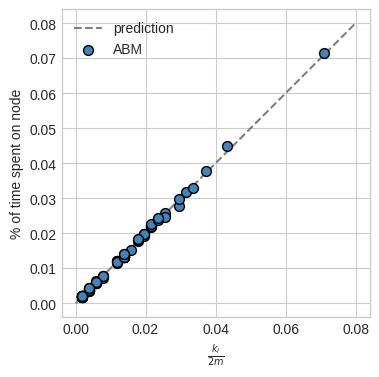

In [31]:

fig, ax = plt.subplots(figsize = (4, 4))
ax.plot([0, 0.08],
         [0, 0.08],
         color = "grey", label = "prediction", linestyle ="--")

ax.scatter(stationary_dist,
            freqs,
            zorder = 100, label = "ABM", facecolors="steelblue", s = 50, edgecolors = "black")

ax.set(xlabel = r"$\frac{k_i}{2m}$",
              ylabel = "% of time spent on node")

ax.set_aspect('equal', 'box')

ax.legend()

That's a match! It is possible to provide probabilistic guarantees on how many simulation steps would be necessary to achieve a specified degree of tolerance in the difference between simulated proportions and the stationary distribution.

### Variation: PageRank

The reason that we parameterized the `RWModel` class with the argument `agent_class` is that we can now implement other random walks, like PageRank, just by modifying the agent behavior. Let's now make a new kind of agent that does the PageRank step. In a PageRank step:

- With probability $\alpha$, the agent teleports to a random node.
- With probability $1 - \alpha$, the agent chooses a neighbor instead does a simple random walk step.

In [46]:
class PageRankAgent(Agent):
  def __init__(self, model, alpha):
    super().__init__(model)
    self.alpha = alpha

  def step(self):

    # list of all nodes I can move to through teleportation
    if np.random.rand() < self.alpha:
      options = list(self.model.grid.G.nodes.keys())
    # from neighbors
    else:
      options = self.model.grid.get_neighborhood(self.pos, include_center = False)

    new_node = self.random.choice(options)
    self.model.grid.move_agent(self, new_node)

1. Teleportation step.
2. Simple random walk step.


That's all we need to do in order to implement PageRank. Let's go ahead and run:

In [47]:
pagerank_model = RWModel(G, PageRankAgent, alpha = 0.15)

for i in range(100000):
  pagerank_model.step()

That's it! Now we could check the match with the stationary distribution like we did last time. Instead, let's simply draw the graph.

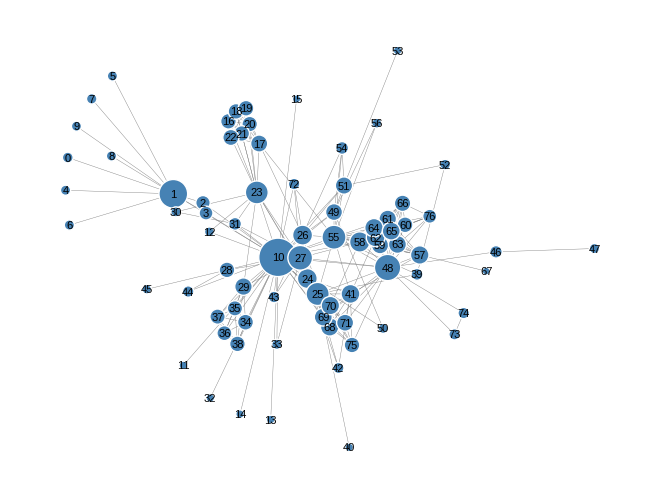

In [48]:
walk_report = pagerank_model.collector.get_agent_vars_dataframe()

counts = walk_report.groupby("node").size()
freqs  = counts / np.sum(counts)

plot_kwargs = {
    "with_labels": True,
    "font_size": 8,
    "edge_color": "gray",
    "edgecolors": "white",
    "width" : 0.3,
    "node_color": "steelblue",
}

g = nx.draw(G,
        node_size = [10000*freqs[i] for i in G.nodes],
        **plot_kwargs)

The simulation-based version of PageRank is actually similar to Google's original implementation of PageRank: rather than solving a linear system, it was sufficient to simply let a webcrawler randomly follow links (with occasional teleportation) and then simply report how often it visited each website. The theory of random walks guarantees that the results will be close to the theoretical PageRank values provided that the number of steps is sufficiently large.

## Multi-Agent Models

Most of the interesting stuff to do with agent-based modeling involves interactions between multiple agents. For a first example of a multi-agent model with interactions, let's consider the *voter model* of opinion dynamics.
[In fact, there are many different models that are all called "the" voter model. The one we'll discuss here is the simplest and most common.]{.aside}

In the voter model, every agent $i$ has a binary opinion $x_i \in \{0,1\}$. In each timestep, agents adopt the opinion of a randomly chosen neighbor.

A decision must be made about whether to update *synchronously* or *asynchronously*. In a synchronous update, every agent takes the same step at exactly the same time. In asynchronous updates, the agents act one at a time, usually in a randomly-selected order. The practical difference between synchronous and asynchronous updating is not *usually* large, but can in some cases make major modeling differences.

For this example, we'll use asynchronous updates. Mesa implements this conveniently using the `shuffle_do` method.

Let's now implement the voter model. We'll call the container model class a `CompartmentalModel`, because we'll reuse it when we get to other models in which agents can be sorted into categories.

In [50]:
class CompartmentalModel(Model):
  def __init__(self, G,
               agent_class,
               possible_states = [0, 1],
               state_density = [0.5, 0.5]):
    super().__init__()
    self.grid = NetworkGrid(G)

    # populate the grid
    for node in list(G.nodes):
      state = np.random.choice(possible_states, p = state_density)
      agent = agent_class(self, state)
      self.grid.place_agent(agent, node)

    # data collector
    self.collector = DataCollector(
        agent_reporters = {"state" : lambda a: a.state}
    )

  def step(self):
    # in random order have agents do their step method
    self.agents.shuffle_do("step")
    self.collector.collect(self)

Now we'll implement a `VoterAgent`. In the `step` method of the `VoterAgent`, the agent inspects the set of its neighbors, chooses one uniformly at random, and then adapts its state. The structure of this step is very similar to the simple random walk; only instead of moving to a new location, the agent instead updates its `state` instance variable.


In [51]:
class VoterAgent(Agent):
  def __init__(self, model, state):
    super().__init__(model)
    self.state = state

  def step(self):
    neighbors = self.model.grid.get_neighbors(self.pos, include_center = False)
    adopt_from = np.random.choice(neighbors)
    self.state = adopt_from.state

Let's run an instance of the voter model and plot the proportion of nodes with opinion 1:

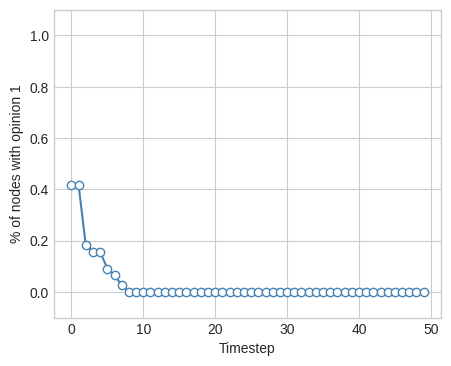

In [73]:
voter_model = CompartmentalModel(G, VoterAgent, [0, 1], [0.5, 0.5])

timesteps = 50
for i in range(timesteps):
    voter_model.step() # remember that each model step updates every agent
report = voter_model.collector.get_agent_vars_dataframe()

fig, ax = plt.subplots(1, 1, figsize = (5, 4))

proportions = report.groupby("Step").mean()

ax.plot(np.arange(timesteps), proportions, color = "steelblue")
ax.scatter(np.arange(timesteps), proportions, color = "steelblue", facecolor = "white", zorder = 100)
labs = ax.set(xlabel = "Timestep", ylabel = "% of nodes with opinion 1", ylim = (-0.1, 1.1))

The proportion of nodes with opinion eventually reaches either 0 or 1 and then stops changing. This is guaranteed to happen in the voter model, with the eventual winning opinion depending on the density of opinions in the initial condition.


## References